In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
#if IN_COLAB:
#!git clone https://github.com/EyupBunlu/QViT_HEP_ML4Sci

Installations

In [2]:
!pip install tensorcircuit
!pip install pennylane

In [3]:
# extra installs due to local git clone
!pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu124
!pip install jax
!pip install optax

Looking in indexes: https://download.pytorch.org/whl/nightly/cu124


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import math
from tqdm.notebook import tqdm
import time
from torchvision.datasets import MNIST
from torchvision import transforms
import h5py
#if IN_COLAB: from QViT_HEP_ML4Sci.QViT import *
from QViT_HEP_ML4Sci.QViT import *
#from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix

torch.set_default_dtype(torch.float32)
torch.set_num_threads(8)

Please first ``pip install -U qiskit`` to enable related functionality in translation module
Please first ``pip install -U cirq`` to enable related functionality in translation module


In [25]:
# hyperparams
device = 'cuda'
n_epochs = 80

Models

In [26]:
mnist_trainset = MNIST(root='./data', train=True, download=True)
n,d= 7,28

transform = transforms.Compose([ transforms.Resize((14,14)), transforms.ConvertImageDtype(torch.float64),transforms.Normalize(0,1)])
data = mnist_trainset.data  # size = (60000, 28, 28_)
data = transform(data)      # size = (60000, 14, 14)
data_patched = patcher(data,[2,14])

mnist_trainset = simple_dataset(data_patched,mnist_trainset.targets)
tr_len = 4000
val_len = 1000
tr_set,val_set,test_set = torch.utils.data.random_split(mnist_trainset,[tr_len,val_len,mnist_trainset.target.shape[0]-tr_len-val_len])
tr_dl = DataLoader(tr_set,batch_size=4096,shuffle=True)
val_dl = DataLoader(val_set,batch_size=4096,shuffle=True)

In [27]:
transformer_dims = {'Token_Dim':data_patched.shape[-2],'Image_Dim':data_patched.shape[-1]}
transformer_hyper = {'n_layers':2,'FC_layers':[10],
                    'head_dimension':8,'Embed_Dim': 16,'ff_dim':32}
transformer_type = {'classifying_type':'max','pos_embedding':True}

Initialization

In [28]:
print(torch.cuda.is_available())
print(f"PyTorch is using: {torch.cuda.get_device_name(torch.cuda.current_device())}")

True
PyTorch is using: NVIDIA GeForce RTX 4070 Ti SUPER


In [29]:
# initialized models
classical_model = HViT(**transformer_dims,**transformer_hyper,**transformer_type,attention_type='classic').to(device)
hybrid2_model = HViT(**transformer_dims,**transformer_hyper,**transformer_type,attention_type='hybrid2').to(device)
# testing QNN
darwin_model = HViT(**transformer_dims,**transformer_hyper,**transformer_type,attention_type='hybrid2').to(device)

In [30]:
# history
reset_classical=True
reset_hybrid2=True
reset_darwin=True

if reset_classical:
    classical_history=None
else:
    classical_history=torch.load('classical history')
    classical_model.load_state_dict(torch.load('classical state dict'))

if reset_hybrid2:
    hybrid2_history=None
else:
    hybrid2_history=torch.load('hybrid2 history')
    hybrid2_model.load_state_dict(torch.load('hybrid2 state dict'))

if reset_darwin:
    darwin_history=None
else:
    darwin_history=torch.load('darwin history')
    darwin_model.load_state_dict(torch.load('darwin state dict'))

Training

In [31]:
classical_optim = torch.optim.Adam(classical_model.parameters(),lr=1e-3)
hybrid2_optim = torch.optim.Adam(hybrid2_model.parameters(),lr=1e-3)
darwin_optim = torch.optim.Adam(darwin_model.parameters(),lr=1e-3)
loss_fn = nn.CrossEntropyLoss(reduction='none')

In [32]:
classical_history = train(classical_model,tr_dl,val_dl,loss_fn,classical_optim,n_epochs,device=device)
torch.save(classical_history, "classical history")

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
# import time

# #checking for best configuration
# batch_sizes = [4096, 2048, 1024, 512]
# epoch_counts = [100, 250, 500, 750, 1000]

# timing_results = []

# for batch_size in batch_sizes:
#     for epochs in epoch_counts:
#             # Prepare the data loader with the current batch size
#             tr_dl = DataLoader(tr_set, batch_size=batch_size, shuffle=True)
#             val_dl = DataLoader(val_set, batch_size=batch_size, shuffle=True)
            
#             start = time.time()
#             history = train(hybrid2_model,tr_dl,val_dl,loss_fn,hybrid2_optim,epochs, device=device)
#             end = time.time()
            
#             elapsed_time = end-start
            
#             max_val_acc = max(history['val_acc'])
#             ratio = max_val_acc / elapsed_time
#             print(f"[{batch_size}, {epochs}]: {ratio:.4f} (Max Accuracy: {max_val_acc:.4f}, Time: {elapsed_time:.2f} seconds)")
#             timing_results.append(f"[{batch_size}, {epochs}]: {ratio:.4f} (Max Accuracy: {max_val_acc:.4f}, Time: {elapsed_time:.2f} seconds)")


In [33]:
# hybrid2 training
hybrid2_history = train(hybrid2_model,tr_dl,val_dl,loss_fn,hybrid2_optim,n_epochs, device=device)
torch.save(hybrid2_history, 'hybrid2 history')

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [34]:
# darwin training
darwin_history = train(darwin_model,tr_dl,val_dl,loss_fn,darwin_optim,n_epochs, device=device)
torch.save(darwin_history, 'darwin history')

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Plotting

"\nplt.figure()\nplt.imshow(confusion_matrix(pred.cpu(),test_set.dataset.target[test_set.indices[:1000]],normalize='true'),\n          vmin=0,vmax=1)\nplt.colorbar()\nplt.title('The normalized confusion matrix')\nprint(f'Wrongly Predicted Ratio:{ (pred != test_set.dataset.target[test_set.indices[:1000]]).sum()/pred.shape[0]}')\n"

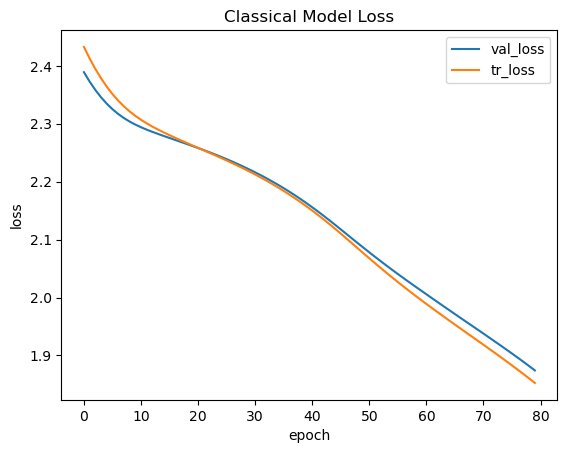

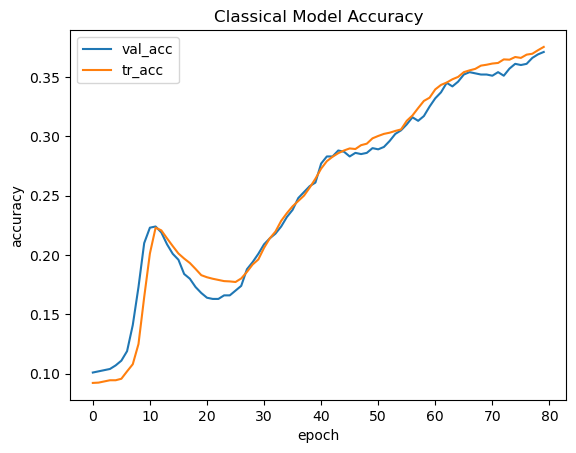

In [35]:
#model(data_patched[[0]].to(device))
#print(f'# of parameters: {sum([np.prod(i.shape) for i in model.parameters()])}')
#model.load_state_dict(torch.load('best_state_on_training_acc'))

plt.plot(classical_history['val'],label='val_loss')
plt.plot(classical_history['tr'],label='tr_loss')
plt.title('Classical Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()
plt.plot(classical_history['val_acc'],label='val_acc')
plt.plot(classical_history['tr_acc'],label='tr_acc')
plt.title('Classical Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

#pred = model(test_set.dataset.data[test_set.indices[:1000]].to(device)).cpu().argmax(axis=1)
"""
plt.figure()
plt.imshow(confusion_matrix(pred.cpu(),test_set.dataset.target[test_set.indices[:1000]],normalize='true'),
          vmin=0,vmax=1)
plt.colorbar()
plt.title('The normalized confusion matrix')
print(f'Wrongly Predicted Ratio:{ (pred != test_set.dataset.target[test_set.indices[:1000]]).sum()/pred.shape[0]}')
"""

tensor(0.2140)


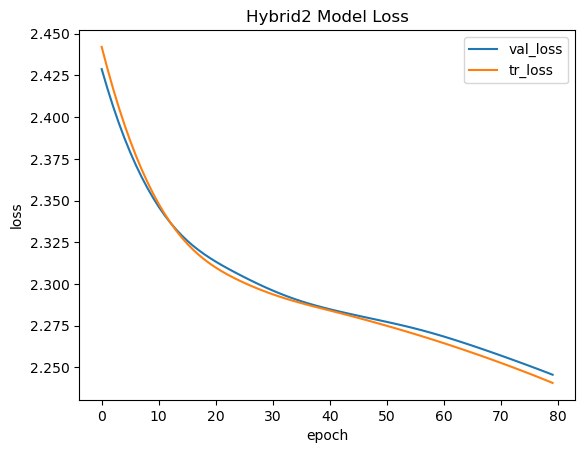

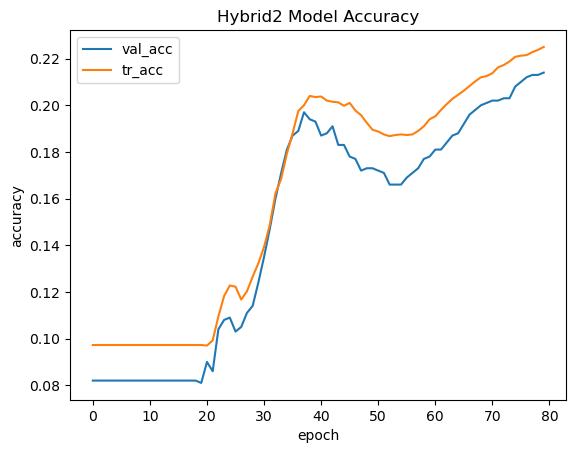

In [36]:
plt.plot(hybrid2_history['val'],label='val_loss')
plt.plot(hybrid2_history['tr'],label='tr_loss')
plt.title('Hybrid2 Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
print(max(hybrid2_history['val_acc']))
plt.figure()
plt.plot(hybrid2_history['val_acc'],label='val_acc')
plt.plot(hybrid2_history['tr_acc'],label='tr_acc')
plt.title('Hybrid2 Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

tensor(0.3670)


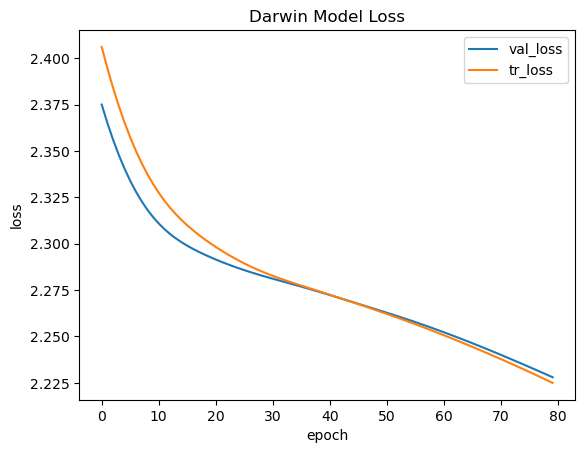

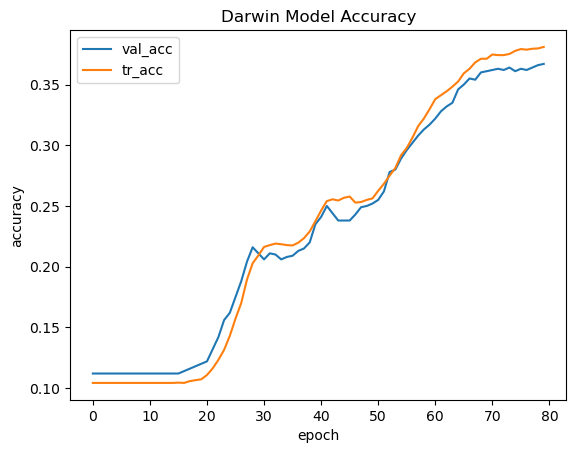

In [37]:
plt.plot(darwin_history['val'],label='val_loss')
plt.plot(darwin_history['tr'],label='tr_loss')
plt.title('Darwin Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
print(max(darwin_history['val_acc']))
plt.figure()
plt.plot(darwin_history['val_acc'],label='val_acc')
plt.plot(darwin_history['tr_acc'],label='tr_acc')
plt.title('Darwin Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

Proof of Concept

In [40]:
data[0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0196, 0.0588, 0.1176, 0.1686, 0.3020,
         0.2706, 0.3961, 0.3137, 0.0275, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0941, 0.4824, 0.6706, 0.8039, 0.8588, 0.8706,
         0.5412, 0.5333, 0.3020, 0.0196, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0902, 0.5725, 0.8157, 0.8588, 0.4824, 0.5255,
         0.1255, 0.0314, 0.0118, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0039, 0.0588, 0.3608, 0.6745, 0.0980, 0.0353,
         0.0078, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0902, 0.5725, 0.4863, 0.1765,
         0.0118, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.1608, 0.6078, 0.7059,
  

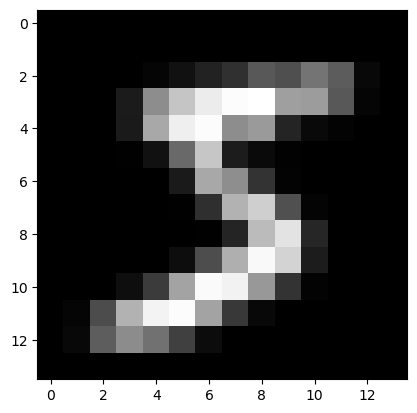

In [20]:
plt.imshow(data[0], cmap='gray')

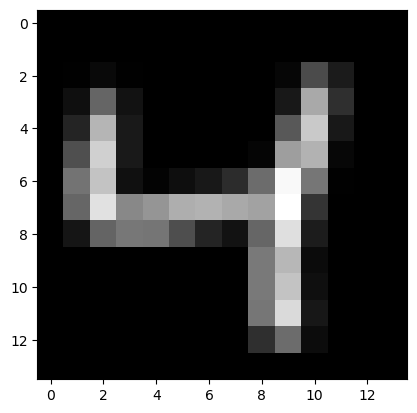

In [21]:
plt.imshow(data[2], cmap='gray')

In [22]:
softmax = torch.nn.Softmax()

In [23]:
def predict(model, data_point):
    pred_probs = softmax(model(data_point))
    return pred_probs

In [38]:
predict(classical_model, data_patched[0])

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [39]:
softmax(classical_model(data_patched[0]))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
softmax(hybrid2_model(data_patched[0]).squeeze())